In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
# sys.path.append("./yolo5/")
from inference import run
import matplotlib.pyplot as plt
from app_utils import bucket_sort, do_sorting
import pandas as pd
import numpy as np  
import streamlit as st 
import cv2
from tempfile import NamedTemporaryFile

app_formal_name = "Planogram Compliance"

# Start the app in wide-mode
st.set_page_config(
    layout="wide", page_title=app_formal_name,
)

result_list = run(weights='best_sku_model.pt',
    source="tmp.png", imgsz=[640, 640])


YOLOv5 🚀 8e8cb19 Python-3.8.10 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3080, 10015MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


In [2]:
bb_df = pd.DataFrame(result_list[0][1].tolist(), columns =["xmin","ymin", "xmax", "ymax", "conf", "cls"])
bb_df.head()

xmin   ymin   xmax   ymax      conf  cls
0  291.0  311.0  353.0  514.0  0.932245  0.0
1  742.0  331.0  804.0  524.0  0.913796  0.0
2  676.0  330.0  737.0  522.0  0.911921  0.0
3  805.0  336.0  867.0  528.0  0.910817  0.0
4  726.0  571.0  785.0  735.0  0.909886  0.0

In [3]:
sorted_df = do_sorting(bb_df)

       

In [5]:
n_rows = sorted_df.line_number.max()
n_cols = sorted_df.groupby('line_number').size().reset_index(name='counts')['counts'].max()
non_null_product = 101
print("master size", n_rows, n_cols)

master size 5.0 26


In [7]:
master_table = np.zeros((int(n_rows), int(n_cols))) + non_null_product

In [14]:
import cv2

sku_data = []
uploaded_img = cv2.imread("tmp.png")
for i, row in bb_df.iterrows():
    xmin, ymin,	xmax,	ymax	= row[["xmin","ymin","xmax","ymax"]].astype(int)
    cv2.rectangle(uploaded_img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    sku_data.append(uploaded_img[ymin:ymax, xmin:xmax])


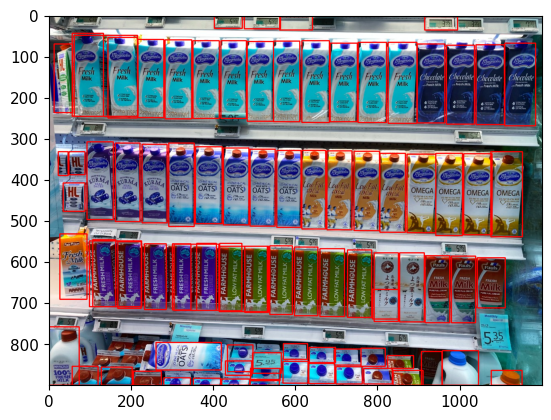

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(uploaded_img)
# plt.show()

In [15]:
from sklearn.cluster import DBSCAN
from imutils import build_montages

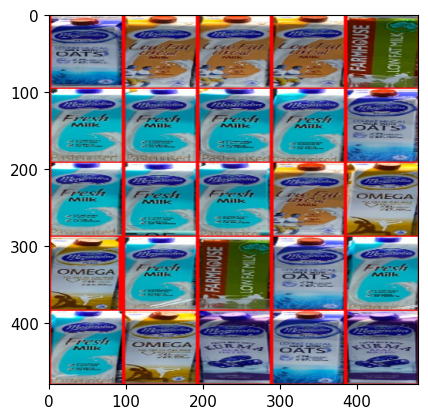

In [16]:
# create a montage using 96x96 "tiles" with 5 rows and 5 columns
montage = build_montages(sku_data, (96, 96), (5, 5))[0]
plt.imshow(montage)

In [83]:
color_features = []
for sku in sku_data:
    hist = cv2.calcHist([sku], #image pixel values array
                        [0, 1, 2], #which channels do you (all RGB channels here)
                        None, #mask, not used in this
                        [4, 4, 4], # how many descriptors do you want per channel?
                        [0, 256, 0, 256, 0, 256] # what is the range of values per color channel?
                    )
    features = cv2.normalize(hist, hist).flatten()
    color_features.append(features)

In [85]:
color_features = np.array(color_features)

In [25]:
import torch
import timm
import torch
import torchvision
# feature_extractor_model = timm.create_model('vgg16', pretrained=True, num_classes=0)
feature_extractor_model = torchvision.models.squeezenet1_1(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /home/abhi/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [59]:
encodings = []
# https://towardsdatascience.com/image-clustering-implementation-with-pytorch-587af1d14123
# https://github.com/KevinMusgrave/pytorch-metric-learning
# https://medium.com/de-bijenkorf-techblog/image-vector-representations-an-overview-of-ways-to-search-visually-similar-images-3f5729e72d07
# https://towardsdatascience.com/find-similar-images-using-autoencoders-315f374029ea
for sku in sku_data:
    h,w = sku.shape[:2]
    sku = cv2.resize(sku, (h*2,w*2), interpolation = cv2.INTER_AREA)
    sku = torch.as_tensor(np.array(sku, dtype=np.float32)).transpose(2,0)[None]
    # encodings.append(feature_extractor_model.forward_features(sku))
    encodings.append(feature_extractor_model(sku).tolist()[0])

In [60]:
encodings = np.array(encodings)

In [68]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=22)
pca.fit(encodings)
x = pca.transform(encodings)

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(x)


KMeans(n_clusters=10, random_state=42)

In [86]:

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(color_features)
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [87]:

# holds the cluster id and the images { id: [images] }
groups = {}
for idx, cluster in zip(range(0,len(encodings)),kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(idx)
    else:
        groups[cluster].append(idx)

In [72]:
# groups

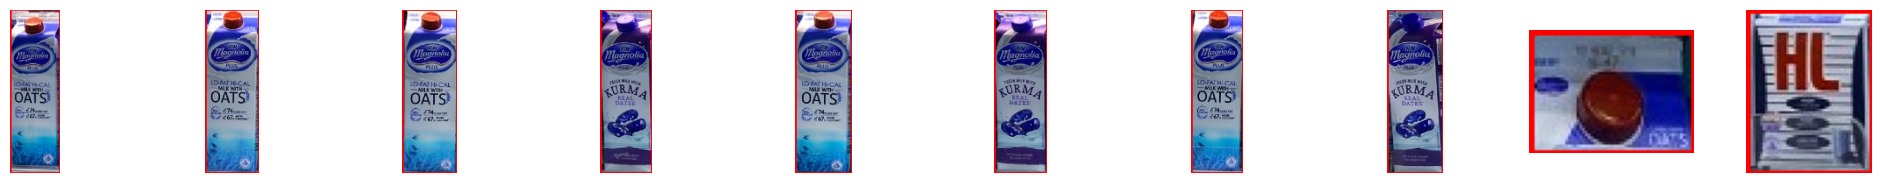

In [107]:
cluster = 1
plt.figure(figsize = (25,25));
# gets the list of filenames for a cluster
idxs = groups[cluster]
# only allow up to 30 images to be shown at a time
if len(idxs) > 30:
    print(f"Clipping cluster size from {len(idxs)} to 30")
    idxs = idxs[:29]
# plot each image in the cluster
for index, idx in enumerate(idxs):
    plt.subplot(10,10,index+1);
    plt.imshow(sku_data[idx])
    plt.axis('off')

/home/abhi/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/abhi/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
2023-01-04 23:59:28.731 WARNING matplotlib.legend: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


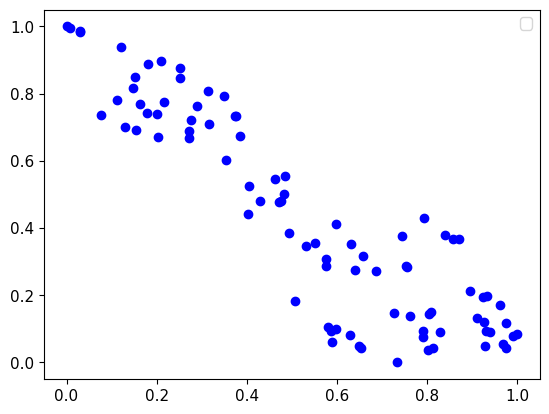

In [64]:
# https://learnopencv.com/t-sne-for-feature-visualization/	
# https://www.kaggle.com/code/colinmorris/visualizing-embeddings-with-t-sne
# https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook
# https://builtin.com/data-science/tsne-python
# https://medium.com/doma/optimizing-models-using-t-sne-plots-268f4c986b2d
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(encodings)
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
# for label in colors_per_class:
#     # find the samples of the current class in the data
#     indices = [i for i, l in enumerate(labels) if l == label]
 
#     # extract the coordinates of the points of this class only
#     current_tx = np.take(tx, indices)
#     current_ty = np.take(ty, indices)
 
#     # convert the class color to matplotlib format
#     color = np.array(colors_per_class[label], dtype=np.float) / 255
 
    # add a scatter plot with the corresponding color and label
ax.scatter(tx, ty, c="blue")
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()

In [65]:

import numpy as np
clt = DBSCAN(metric="euclidean",eps=0.1, min_samples=2, n_jobs=-1)
clt.fit(encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
numUniqueFaces

0

In [63]:
numUniqueFaces

0

In [ ]:
# loop over the unique face integers
for labelID in labelIDs:
	# find all indexes into the `data` array that belong to the
	# current label ID, then randomly sample a maximum of 25 indexes
	# from the set
	print("[INFO] faces for face ID: {}".format(labelID))
	idxs = np.where(clt.labels_ == labelID)[0]
	idxs = np.random.choice(idxs, size=min(25, len(idxs)),
		replace=False)
	# initialize the list of faces to include in the montage
	skus = []
    # loop over the sampled indexes
	for i in idxs:
		# load the input image and extract the sku ROI
		sku = data[i]
		# force resize the face ROI to 96x96 and then add it to the
		# sku montage list
		sku = cv2.resize(face, (96, 96))
		skus.append(sku)

In [3]:

uploaded_img = cv2.imread("tmp.png")
# cv2.imwrite("tmp.png", uploaded_img)

master = cv2.imread('./sample_master_planogram.jpeg')

master.shape, uploaded_img.shape

((3024, 4032, 3), (900, 1200, 3))

In [3]:
# Now do something with the image! For example, let's display it:
# st.image(opencv_image, channels="BGR")

# uploaded_img = '/content/drive/My Drive/0.CV/0.Planogram_Compliance/planogram_data/images/test/IMG_5718.jpg'
# result_list = run_yolo_v5(weights='base_line_best_model_exp5.pt',
#     source="tmp.png", imgsz=[640, 640])



In [ ]:

bb_df = pd.DataFrame(result_list[0][1].tolist(), columns =["xmin","ymin", "xmax", "ymax", "conf", "cls"])
sorted_df = do_sorting(bb_df)

n_rows = 3
n_cols = 16
master_table = np.zeros((n_rows, n_cols))
master_annotations = [[(32, 12), (8, 4)], [(36, 1), (41, 6), (50, 4), (51, 3), (52, 2)], [(23, 5), (24, 6), (54,5)]]

for i, row in enumerate(master_annotations):
    idx = 0
    for product, count in row:
        master_table[i, idx:idx+count] = product
        idx = idx + count

non_null_product = 101
detected_table = np.zeros((n_rows, n_cols)) + 100
for i, row  in sorted_df.groupby('line_number'):
    # print(f"Adding products in the row {i} to the detected planogram", row.cls.tolist())
    products  =row.cls.tolist()
    detected_table[int(i-1), 0:len(products)] = products

score = (master_table == detected_table).sum() / (master_table != non_null_product).sum()